# Scaling Neural Nets and Efficient Training

## Estimating Compute Costs
> Back of the Envelope Calculations : A quick way to get rough estimates


**[LLaMA 3.1](https://github.com/meta-llama/llama-models/blob/main/models/llama3_1/MODEL_CARD.md)** from Meta.AI launched very recently. The model is available in 8B, 70B and 405B sizes and is outperforming a number of existing LLMs on various benchmarks. 

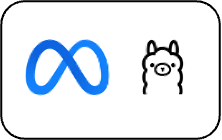

## But how much does it cost to train such model(s)?
<img src="./assets/ch_09_01.png">

> Source: https://x.com/deedydas/status/1629312480165109760

__Assumptions__
For the sake of our understanding, we will make the following assumptions:
- Ignore costs associated with preparing datasets
- Ignore costs associated with training restarts, infra-failures, etc.
- Cost of forward and backward pass is set to 1
- Assume a very simplified view of overhead associated with multi-GPU/multi-node clusters by setting a standard efficiency ratio (ex: 0.25 efficiency in terms of TFLOPs)

### Model Parameters
- Model Size : 405 **B**illion
- Training Dataset : 15 **T**rillion

In [39]:
# define model and dataset size
model_name = 'LLaMA3.1'
model_size = 405e9
dataset_size = 15e12 #15Trillion Tokens. Hint use scientific notation
forward_backward_pass_ops = 1 # better estimate from table 1 @ Kaplan et. al.

### Compute Required 

In [40]:
APPROX_COMPUTE_REQUIRED = model_size * dataset_size * forward_backward_pass_ops
print(f"We will need approximately \033[1m{APPROX_COMPUTE_REQUIRED}\033[0m FLOPs to train \033[1m{model_name}\033[0m")
print("\t,where FLOPs is Floating Point Operations Per Second")

We will need approximately 6.075e+24 FLOPs to train LLaMA3.1
	,where FLOPs is Floating Point Operations Per Second


### GPU Performance and Compute Time

In [41]:
# cost source: https://fullstackdeeplearning.com/cloud-gpus/
gpu_details = {
    't4':{
        'flops':0.081e14, #colab free
        'cost':0.21, #usd per hour
        'ram':16 #gb
    },
    'v100':{
        'flops':0.164e14, #standard nvidia
        'cost':0.84, #usd per hour
        'ram':32 #gb
        
    },
    'a100':{
        'flops':3.12e14, #standard nvidia
        'cost':1.1, #usd per hour
        'ram':80 #gb
    },
}
hour_constant = 60*60 # number of seconds in an hour
gpu_efficiency = 0.5 #50% efficiency

In [42]:
gpu = #TODO: Select one of the GPUs, ex: a100
COMPUTE_TIME = APPROX_COMPUTE_REQUIRED/(gpu_details.get(gpu).get('flops')*hour_constant*gpu_efficiency)
print(f"We will need approximately \033[1m{COMPUTE_TIME:.2E}\033[0m GPU hours to train \033[1m{model_name}\033[0m on a \033[1m{gpu}\033[0m GPU")

We will need approximately 1.08E+07 GPU hours to train LLaMA3.1 on a a100 GPU


### Cost of Training

In [43]:
TRAINING_COST = COMPUTE_TIME*gpu_details.get(gpu).get('cost')
print(f"We will need approximately spend \033[1m${TRAINING_COST:,.2f}\033[0m to train \033[1m{model_name}\033[0m on a \033[1m{gpu}\033[0m GPU")

We will need approximately spend $11,899,038.46 to train LLaMA3.1 on a a100 GPU


## Big but How Big?

The latest and the greatest seem to be a thing only the _GPU-rich_ can afford to play with. The exponential increase in the size of models along with their training datasets (we saw GPT vs GPT2 vs GPT3.5 in the previous module) indicates scale is our best friend. 

Work by Kaplan et. al. in the work titled **[Scaling Laws for Neural Language Models](https://arxiv.org/pdf/2001.08361)** presents some interesting takeaways. 
We will use the notation from paper as:
- **$N$**: Model parameters excluding embeddings
- **$D$**: Size of the dataset
- **$C$**: Compute used for training the model

_Scale is a function of $N$, $D$ and $C$_


Let's look at some of the insights from the paper:

1. Performance depends **strongly on scale** and weakly on model shape
2. Performance improves predictably as long as we **scale up** **$N$** and **$D$** : 
_Every time we increase model size 8x, we only need to increase the dataset by roughly 5x_
3. Large Models are more **sample efficient** than small models reaching same level of performance with fewer steps and fewer data points

<img src="./assets/ch_09_02.png">

> Source: [Kaplan et. al.](https://arxiv.org/pdf/2001.08361)

## So Should We Just Keep Growing?

**TL;DR**: Probably not! 

**Long Answer**: In their work titled [Training Compute-Optimal Large Language Models](https://arxiv.org/pdf/2203.15556) Hoffman et. al. build upon the previous works to showcase that current(_2022_) set of models are **significantly under trained** or the current set of LLMs are far too large for their compute budgets and datasets!

They present a 70B parameter model titled **Chincilla** which was:
- 4x smaller than 280B parameter Gopher
- trained on 4x more data than Gopher, 1.3T tokens vs 300B tokens

and yet **outperformed** Gopher on every task they evaluated!

<img src="./assets/ch_09_03.png">

> Source: [Hoffman et. al.](https://arxiv.org/pdf/2203.15556)
> Fine-print: Though undertrained, LLMs increasingly show performance improvement with increasing dataset size

## Ok, So I have a lot of Compute, What's the Problem?

The scaling laws are all good for BigTech, but you could say that most companies have a lot of compute available. Where is the problem? Let us understand this with a simple example walk through

Assumptions/Setup:
- System RAM (CPU): 32GB
- GPU RAM : 32 GB
- Model Size : 20B
- Parameter Size: 2bytes

In [1]:
from utils import humanbytes, memory_fit

In [2]:
CPU_RAM = 32e9 # 32GB
GPU_RAM = 32e9 #32GB
model_size = 20e9 #20B
param_size = 2

In [6]:
inference_memory = #TODO: Model Size Multiplied with Bytes per Parameter
inference_outcome = memory_fit(inference_memory,CPU_RAM,GPU_RAM)

In [8]:
print(f"Amount of memory needed to load model for inference=\033[1m{humanbytes(inference_memory)}\033[0m")
print()
print(f"Can this work on my setup?\n\033[1m{inference_outcome}\033[0m")

Amount of memory needed to load model for inference=40.00 GB

Can this work on my setup?
Yes, but fit needs both CPU and GPU



This is good for inference but we need to train/fine-tune this model.
We need to accomodate for:
- **Gradients/backpropagation** : Size same as model size
- **Optimizer States** (ex: ADAM needs momentum and variance, can't be FP16): typically 12x of model size

In [9]:
gradient_params = model_size
optimizer_memory = model_size*12

In [10]:
finetune_memory = inference_memory + gradient_params + optimizer_memory
finetune_outcome = memory_fit(finetune_memory,CPU_RAM,GPU_RAM)

In [11]:
print(f"Amount of memory needed to load model for fintuning=\033[1m{humanbytes(finetune_memory)}\033[0m")
print()
print(f"Can this work on my setup?\n\033[1m{finetune_outcome}\033[0m")

Amount of memory needed to load model for fintuning=300.00 GB

Can this work on my setup?
Nope, does not fit available memory


We need more memory (and faster GPUs). But just by usual scaling we would need:

In [38]:
additional_gpus = #TODO: HINT Required Memory / RAM per GPU
print(f"We Would need roughly need \033[1m{additional_gpus} more GPUs\033[0m to setup fine-tuning")

We Would need roughly need 8.0 more GPUs to setup fine-tuning


In [47]:
gpu = 'v100' # GPU RAM size is same for our example
total_gpu_cost_per_hour = gpu_details.get(gpu).get('cost')*(additional_gpus+1)
print(f"We Would spend roughly \033[1m${total_gpu_cost_per_hour}/hr\033[0m to for fine-tuning with this setup")

We Would spend roughly $7.56/hr to for fine-tuning with this setup
